This notebook provides some additional analysis on the results report in "Validation of AMBER/GAFF for Relative Free Energy Calculations".  https://chemrxiv.org/articles/Validation_of_AMBER_GAFF_for_Relative_Free_Energy_Calculations/7653434

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
from scipy.stats import norm, pearsonr
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from collections import namedtuple

As a first step, we want to grab the data from a set of Excel worksheets in the supporting material.  The Excel workbook has multiple sheets, we need to get the names of those sheets. Fortunately Pandas has all sorts of facilities for manipulating Excel files.

In [2]:
xls = pd.ExcelFile("FEP_vs_GTI-dG-SI.xlsx")
sheet_names = xls.sheet_names

Now we can define a function that will grab the data from a particular sheet. In this case the data we want is in columns 15-17. We'll grab those columns and create a new dataframe with the columns labeled as Experimental  Δ G, FEP  Δ G, and TI  Δ G. We will also include columns with the target and with the target concatenated with a sequential index. Ok, in truth, we're going to label the columns as Experimental_dG, etc for convenience.  The final row in columsn 15-17 is the sum of the values in the column.  We don't want this so we'll use df = df.query("Experimental_dG > -20") to get rid of the sum row.

In [3]:
def get_data_from_sheet(xls,sheet_name,col_names):
    df = xls.parse(sheet_name=sheet_name,header=None)
    df = df[df.columns[15:18]]
    df.columns = col_names
    df.dropna(inplace=True)
    df = df.query("Experimental_dG > -20")
    rows,_ = df.shape
    df.insert(0,"Name",[sheet_name]*rows)
    df.insert(1,"ID",[f"{sheet_name}_{x}" for x in range(0,rows)])
    return df

Define the number of decimal places displayed in the Pandas table.

In [4]:
pd.options.display.float_format = '{:,.2f}'.format

Read the Excel sheets and put the data into a Pandas dataframe.

In [5]:
col_names = ["Experimental_dG","FEP_dG","TI_dG"]
master_df = pd.DataFrame(columns=["Name","ID"]+col_names)
for sheet in sheet_names:
    tmp_df = get_data_from_sheet(xls,sheet,col_names)
    master_df = master_df.append(tmp_df)   
master_df.sort_values("Name",inplace=True)

Make a plot like the one in Wang et al. https://paperpile.com/view/1f98be30-9434-06cd-8ded-d750d0dcc318 I find this plot very confusing, but I wanted to prove to myself that I could reproduce it.


In [19]:
def crowded_fep_plot(df, x_col, y_col, hue_col, x_label, y_label):
    sns.set(rc={'figure.figsize': (12, 12)}, font_scale=1.5)
    sns.set_style("white")
    ax = sns.scatterplot(x=x_col, y=y_col, hue=hue_col, data=df, s=100)
    # plot the unity line
    ax.plot(ax.get_xlim(), ax.get_ylim(), linewidth=2, color='blue')
    # get the axis limits for later
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    # plot lines showing 2 kcal error above and below the unity line
    pad = 2
    ax.plot([xmin, xmax], [ymin + pad, ymax + pad], color="black")
    ax.plot([xmin, xmax], [ymin - pad, ymax - pad], color="black")
    # reset the axis limits, otherwise the added lines will skew the axes
    ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
    ax.set(xlabel=x_label, ylabel=y_label)
    handles, labels = ax.get_legend_handles_labels()
    # move the legend outside the plot and make it a little prettier
    legend_rows = len(handles)
    _ = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,
                   handles=handles[1:legend_rows], labels=labels[1:legend_rows])

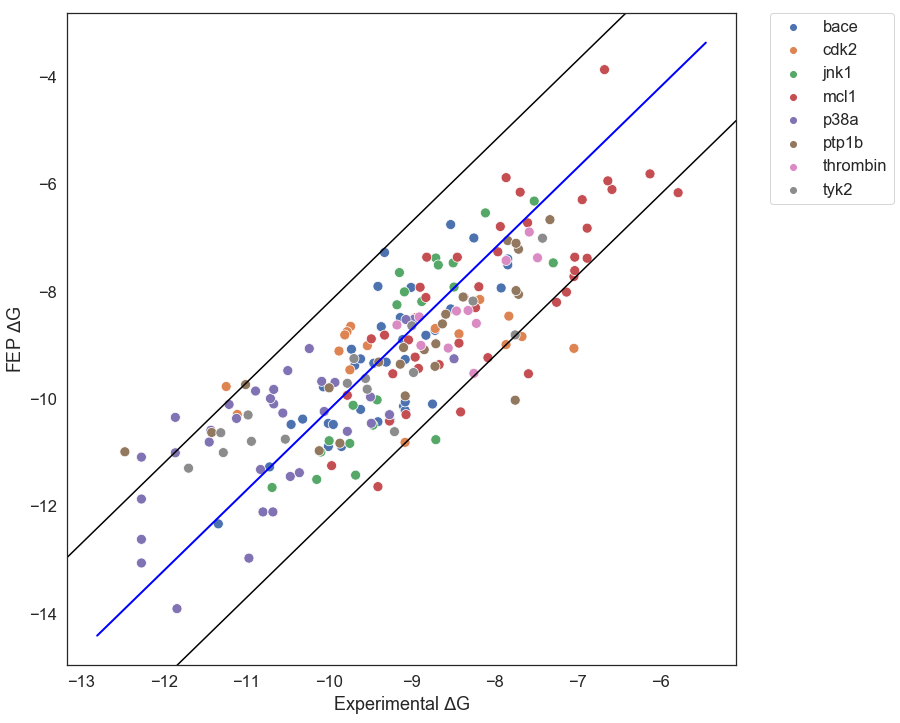

In [20]:
crowded_fep_plot(master_df,"Experimental_dG","FEP_dG","Name","Experimental $\Delta$G","FEP $\Delta$G")

For what it's worth, here's the same thing for the TI data

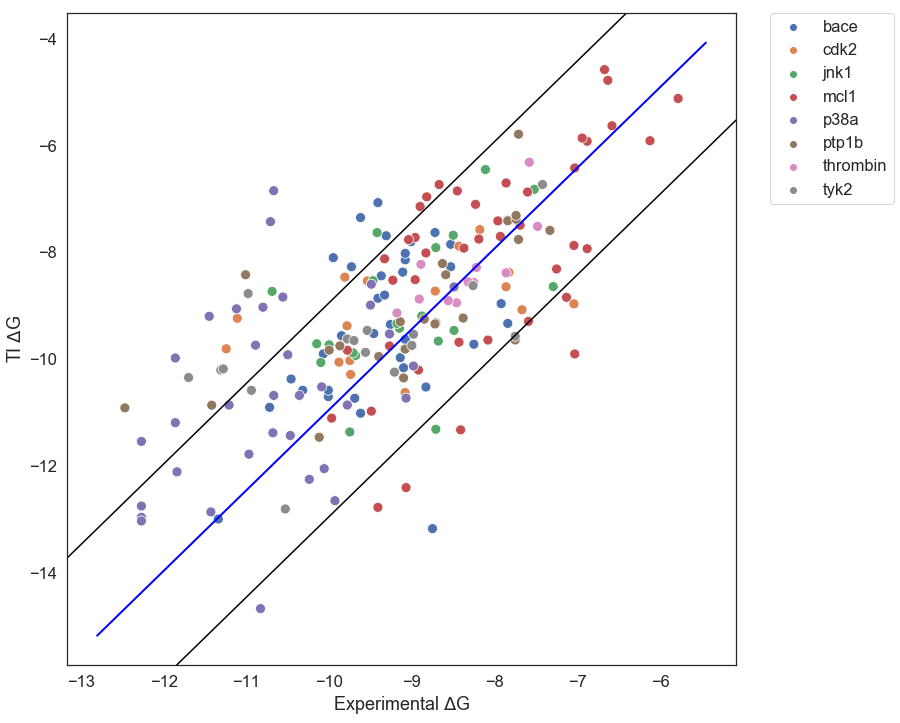

In [21]:
crowded_fep_plot(master_df,"Experimental_dG","TI_dG","Name","Experimental $\Delta$G","TI $\Delta$G")

Creating plots with each target shown as a different facet will be more informative. First let's define a function to plot the factets.

In [8]:
def draw_dG_facet(*args,**kwargs):
    xlim, ylim = np.array([[-15,-4],[-15,-4]])
    ax = sns.scatterplot(*args,**kwargs)
    r2 = pearsonr(args[0],args[1])[0]**2
    pad = 2
    ax.text(-14,-6,f"$R^2$={r2:.2f}")
    ax.plot(xlim,ylim,linewidth=2, color='blue')
    ax.plot(xlim,ylim+pad,color="black",linestyle="--")
    ax.plot(xlim,ylim-pad,color="black",linestyle="--")
    ax.set(xlim=xlim,ylim=ylim)

Now we'll define a function to plot a grid of facets

In [ ]:
def draw_facet_grid(group_col,x_col,y_col,x_name=None,y_name=None):
    sns.set(font_scale=1)
    sns.set_style("white")
    g = sns.FacetGrid(master_df,col="Name",col_wrap=4)
    g.map(draw_dG_facet,"Experimental_dG","FEP_dG")
    g.set_titles(col_template="{col_name}")
    g.set_xlabels("Experimental $\Delta$G")
    _= g.set_ylabels("FEP $\Delta$G")

With these functions in hand, we can make our plots. First, we'll make the plot for FEP.

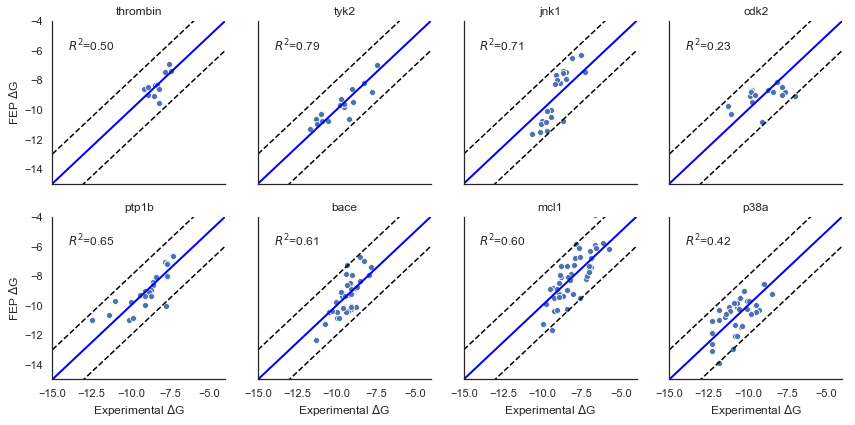

In [9]:
sns.set(font_scale=1)
sns.set_style("white")
g = sns.FacetGrid(master_df,col="Name",col_wrap=4)
PlotConfig = namedtuple('PlotConfig','xlim,ylim,text_pos')
pc = PlotConfig(xlim=[-15,-4],
                ylim=[-15,-4],
                text_pos=[-14,-6])
plot_limits = np.array([[-15,-4],[-15,-4]])
g.map(draw_dG_facet,"Experimental_dG","FEP_dG")
g.set_titles(col_template="{col_name}")
g.set_xlabels("Experimental $\Delta$G")
_= g.set_ylabels("FEP $\Delta$G")

Now we'll make the same plot for AMBER TI. Looking back and fourth to compare the two datasets is kind of tedious. We'll address that below.

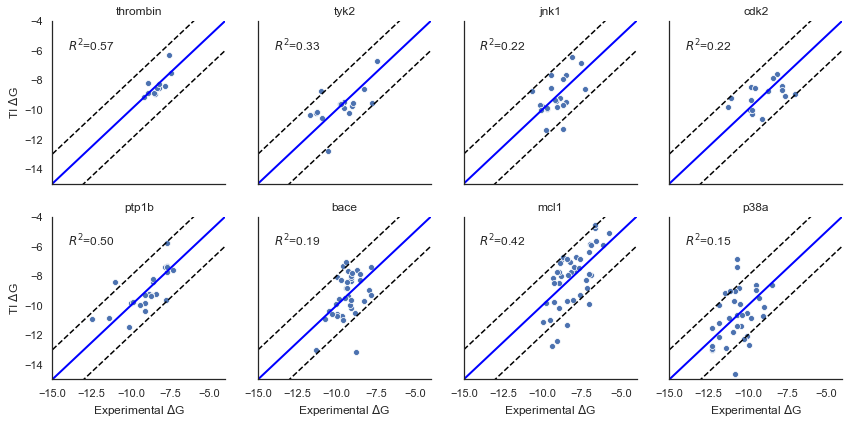

In [10]:
g = sns.FacetGrid(master_df,col="Name",col_wrap=4)
plot_limits = np.array([[-15,-4],[-15,-4]])
m = g.map(draw_dG_facet,"Experimental_dG","TI_dG")
_ = g.set_titles(col_template="{col_name}")
g.set_xlabels("Experimental $\Delta$G")
_= g.set_ylabels("TI $\Delta$G")

Let's calculate Pearson r and format this as a table. This way we can make sure we are getting the same values for r that are reported in the Schrödinger paper. All of the values below are the same with the exception of jnk1. The Schrödinger paper reports 0.85 and I got 0.84. I can live with that.

In [12]:
gb = master_df.groupby("Name")
res = []
for k,v in gb:
    res.append([k,len(v),pearsonr(v.Experimental_dG,v.FEP_dG)[0],pearsonr(v.Experimental_dG,v.TI_dG)[0]])
res_df = pd.DataFrame(res,columns=["Name","Num","FEP Correlation","TI Correlation"])

In [13]:
res_df

,Name,Num,FEP Correlation,TI Correlation
0,bace,36,0.78,0.43
1,cdk2,16,0.48,0.47
2,jnk1,21,0.84,0.47
3,mcl1,42,0.77,0.65
4,p38a,34,0.65,0.38
5,ptp1b,23,0.80,0.71
6,thrombin,11,0.71,0.76
7,tyk2,16,0.89,0.57


As mentioned above, we'd like to put the plots for FEP and TI side by side for each of the plots. We can use the "melt" function with Pandas to reshape the data.

In [18]:
mdf = master_df.melt(id_vars=["Name","ID","Experimental_dG"])
mdf["DataSet"] = mdf.Name + "_" + mdf.variable.str.replace("_dG","")
mdf.sort_values("DataSet",inplace=True)
cols = list(mdf.columns)
cols[4] = "Predicted_dG"
mdf.columns = cols

In [19]:
mdf.head()

,Name,ID,Experimental_dG,variable,Predicted_dG,DataSet
110,bace,bace_23,-11.34,FEP_dG,-12.33,bace_FEP
118,bace,bace_31,-9.33,FEP_dG,-7.28,bace_FEP
117,bace,bace_30,-7.84,FEP_dG,-7.40,bace_FEP
116,bace,bace_29,-9.01,FEP_dG,-7.93,bace_FEP
115,bace,bace_28,-8.25,FEP_dG,-7.01,bace_FEP


Now we can make a more informative plot with the FEP and TI results side by side. 

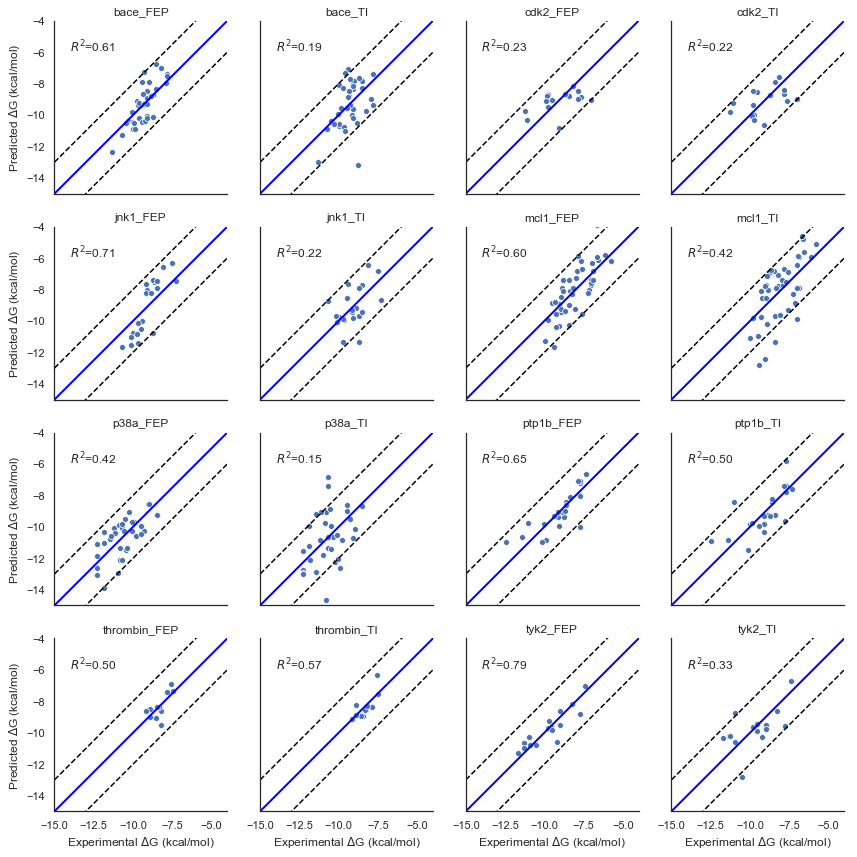

In [20]:
sns.set(font_scale=1)
sns.set_style("white")
g = sns.FacetGrid(mdf,col="DataSet",col_wrap=4)
g.map(draw_dG_facet,"Experimental_dG","Predicted_dG")
_ = g.set_titles(col_template="{col_name}")
g.set_xlabels("Experimental $\Delta$G (kcal/mol)")
_= g.set_ylabels("Predicted $\Delta$G (kcal/mol)")

It's also informative to look at the correlations as bar plots.  Of course, when we do this, we need to include error bars. Let's define a function to calculate the error for the Pearson r. 

In [21]:
def pearson_confidence(r, num, interval=0.95):
    """
    Calculate upper and lower 95% CI for a Pearson r (not R**2)
    Inspired by https://stats.stackexchange.com/questions/18887
    :param r: Pearson's R
    :param num: number of data points
    :param interval: confidence interval (0-1.0)
    :return: lower bound, upper bound
    """
    stderr = 1.0 / math.sqrt(num - 3)
    z_score = norm.ppf(interval)
    delta = z_score * stderr
    lower = math.tanh(math.atanh(r) - delta)
    upper = math.tanh(math.atanh(r) + delta)
    return lower, upper

With this function in hand, we can calculate the upper and lower bounds for the correlations

In [22]:
fep_bounds = [pearson_confidence(x,y) for (x,y) in res_df[["FEP Correlation","Num"]].values]
res_df["FEP_LB"] = [x[0] for x in fep_bounds]
res_df["FEP_UB"] = [x[1] for x in fep_bounds]
ti_bounds = [pearson_confidence(x,y) for (x,y) in res_df[["TI Correlation","Num"]].values]
res_df["TI_LB"] = [x[0] for x in ti_bounds]
res_df["TI_UB"] = [x[1] for x in ti_bounds]

In [23]:
res_df

,Name,Num,FEP Correlation,TI Correlation,FEP_LB,FEP_UB,TI_LB,TI_UB
0,bace,36,0.78,0.43,0.64,0.87,0.18,0.64
1,cdk2,16,0.48,0.47,0.06,0.75,0.05,0.75
2,jnk1,21,0.84,0.47,0.69,0.93,0.13,0.72
3,mcl1,42,0.77,0.65,0.64,0.86,0.47,0.78
4,p38a,34,0.65,0.38,0.45,0.79,0.11,0.60
5,ptp1b,23,0.80,0.71,0.63,0.90,0.47,0.85
6,thrombin,11,0.71,0.76,0.29,0.90,0.38,0.92
7,tyk2,16,0.89,0.57,0.75,0.95,0.19,0.80


Now we can make a plot of the correlations with the error bars. 

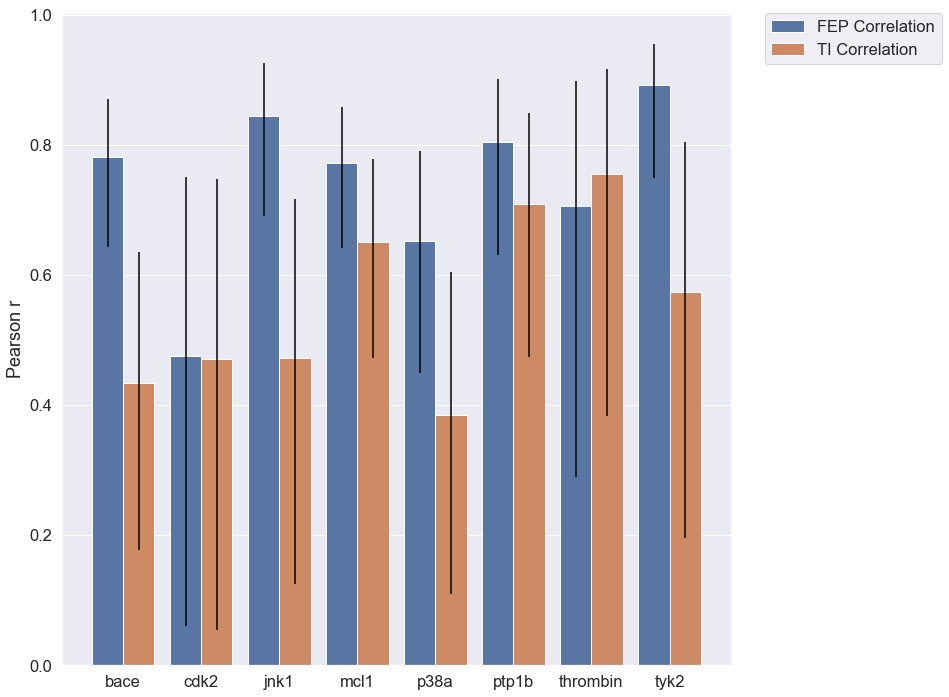

In [24]:
sns.set(rc={'figure.figsize':(12,12)},font_scale=1.5)
ax = sns.barplot(x="Name",y="value",hue="variable",data=melt_res_df)
x_pos = np.arange(8)-0.2
y_val = res_df["FEP Correlation"]
lb = y_val - res_df.FEP_LB
ub = res_df.FEP_UB - y_val
ax.errorbar(x_pos,y_val,yerr=[lb,ub],fmt="none",capsize=0,color='black')
x_pos = np.arange(8)+0.2
y_val = res_df["TI Correlation"]
lb = y_val - res_df.TI_LB
ub = res_df.TI_UB - y_val
a = ax.errorbar(x_pos,y_val,yerr=[lb,ub],fmt="none",capsize=0,color='black')
handles, labels = ax.get_legend_handles_labels()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., handles=handles[0:2], labels=labels[0:2])
_ = ax.set(xlabel='', ylabel="Pearson r")

As [Anthony Nicolls](https://link.springer.com/article/10.1007/s10822-016-9904-5) points out, when we have a data set like this with dependent errors, the fact that error bars overlap does not necessarily imply that the methods are equivalent.  However we can use the mean of differences / std deviation of the differences to calculate [Cohen's d](https://machinelearningmastery.com/effect-size-measures-in-python/), which measures the effect size. Cohen’s d measures the difference between the mean from two Gaussian-distributed variables. It is a standard score that summarizes the difference in terms of the number of standard deviations. Because the score is standardized, there is a table for the interpretation of the result, summarized as:

- Small Effect Size: d=0.20
- Medium Effect Size: d=0.50
- Large Effect Size: d=0.80


In [25]:
delta = res_df["FEP Correlation"].values-res_df["TI Correlation"].values
np.mean(delta)/np.std(delta)

1.2137416942335346

We get a Cohen's d of 1.2, which is a very large effect size. 

To look at this visually, let's plot a kernel density estimate for the distributions. 

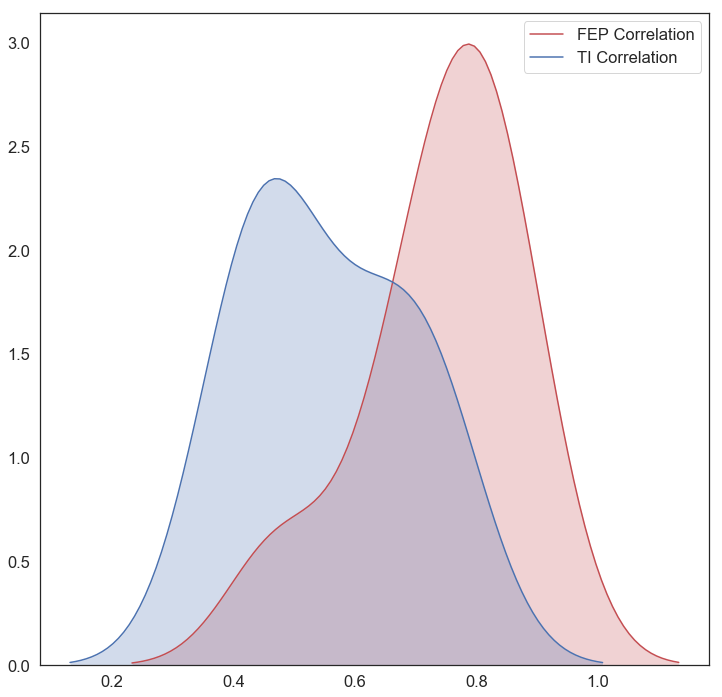

In [27]:
sns.set(font_scale=1.5)
sns.set_style("white")
sns.kdeplot(res_df["FEP Correlation"],color="r",shade=True)
_ = sns.kdeplot(res_df["TI Correlation"],color="b",shade=True)

We can also calculate Cohen's d for the RMSE.

In [28]:
gb = master_df.groupby("Name")
res = []
for k,v in gb:
    res.append([k,mean_squared_error(v.Experimental_dG,v.FEP_dG),mean_squared_error(v.Experimental_dG,v.TI_dG)])
rmse_df = pd.DataFrame(res,columns=["Name","FEP RMSE","TI RMSE"])

In [29]:
delta = rmse_df["FEP RMSE"].values - rmse_df["TI RMSE"].values
np.mean(delta)/np.std(delta)

-1.0813375331578459

Again we have a very large effect size